In [1]:
import torch_geometric

In [2]:
import math
import logging
import time
import sys
import random
import argparse
import pickle
from pathlib import Path
import torchvision.transforms as transforms
import torch
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score
from model.tgn import TGN
#from mixup import shuffleData
from utils.utils import EarlyStopMonitor, get_neighbor_finder, Net
from utils.data_processing import compute_time_statistics, get_data_node_classification
#from evaluation.evaluation import eval_node_classification, shuffleData

In [3]:
import os.path as osp
import os
import argparse
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, Coauthor
from torch_geometric.data import Data
from torch_geometric.utils import degree
from torch_sparse import SparseTensor
import torch_geometric.transforms as T

import pdb
import numpy as np
import random
import copy

In [4]:
import math
import copy
import numpy as np
import torch
from sklearn.metrics import average_precision_score, roc_auc_score

def idNode(data, id_new_value_old):
    data = copy.deepcopy(data)
    
    data.x = None
    data.y[data.val_id] = -1
    
    data.y[data.test_id] = -1
    
    data.y = data.y[id_new_value_old]

    data.train_id = None
    data.test_id = None
    data.val_id = None

    id_old_value_new = torch.zeros(id_new_value_old.shape[0], dtype = torch.long)
    id_old_value_new[id_new_value_old] = torch.arange(0, id_new_value_old.shape[0], dtype = torch.long)
    row = data.edge_idxs[0]
    col = data.edge_idxs[1]
    row = id_old_value_new[row]
    col = id_old_value_new[col]
    data.edge_idxs = torch.stack([row, col], dim=0)

    return data

def shuffleData(data):
    data = copy.deepcopy(data)
    
    id_new_value_old = np.arange(data.shape[0])
   
    train_id_shuffle = copy.deepcopy(data.train_id)
   
    np.random.shuffle(train_id_shuffle)
    
    id_new_value_old[data.train_id] = train_id_shuffle
    
    data = idNode(data, id_new_value_old)
   
    return data, id_new_value_old


def eval_edge_prediction(model, negative_edge_sampler, data, n_neighbors, batch_size=200):
  # Ensures the random sampler uses a seed for evaluation (i.e. we sample always the same
  # negatives for validation / test set)
  assert negative_edge_sampler.seed is not None
  negative_edge_sampler.reset_random_state()

  val_ap, val_auc = [], []
  with torch.no_grad():
    model = model.eval()
    # While usually the test batch size is as big as it fits in memory, here we keep it the same
    # size as the training batch size, since it allows the memory to be updated more frequently,
    # and later test batches to access information from interactions in previous test batches
    # through the memory
    TEST_BATCH_SIZE = batch_size
    num_test_instance = len(data.sources)
    num_test_batch = math.ceil(num_test_instance / TEST_BATCH_SIZE)

    for k in range(num_test_batch):
      s_idx = k * TEST_BATCH_SIZE
      e_idx = min(num_test_instance, s_idx + TEST_BATCH_SIZE)
      sources_batch = data.sources[s_idx:e_idx]
      destinations_batch = data.destinations[s_idx:e_idx]
      timestamps_batch = data.timestamps[s_idx:e_idx]
      edge_idxs_batch = data.edge_idxs[s_idx: e_idx]

      size = len(sources_batch)
      _, negative_samples = negative_edge_sampler.sample(size)

      pos_prob, neg_prob = model.compute_edge_probabilities(sources_batch, destinations_batch,
                                                            negative_samples, timestamps_batch,
                                                            edge_idxs_batch, n_neighbors)

      pred_score = np.concatenate([(pos_prob).cpu().numpy(), (neg_prob).cpu().numpy()])
      true_label = np.concatenate([np.ones(size), np.zeros(size)])

      val_ap.append(average_precision_score(true_label, pred_score))
      val_auc.append(roc_auc_score(true_label, pred_score))

  return np.mean(val_ap), np.mean(val_auc)


def eval_node_classification(tgn, decoder, data, edge_idxs, batch_size, n_neighbors):
  pred_prob = np.zeros(len(data.sources))
  num_instance = len(data.sources)
  num_batch = math.ceil(num_instance / batch_size)

  with torch.no_grad():
    decoder.eval()
    tgn.eval()
    
    s_idx =  0
    e_idx = batch_size

    sources_batch = data.sources[s_idx: e_idx]
    destinations_batch = data.destinations[s_idx: e_idx]
    timestamps_batch = data.timestamps[s_idx:e_idx]
    edge_idxs_batch = edge_idxs[s_idx: e_idx]
    labels_batch = data.labels[s_idx: e_idx]
    source_embedding, destination_embedding, _ = tgn.compute_temporal_embeddings(sources_batch,
                                                                                   destinations_batch,
                                                                                   destinations_batch,
                                                                                   timestamps_batch,
                                                                                   edge_idxs_batch,
                                                                                   n_neighbors)
    
    
    
    
    ##################
    node_id = np.arange(source_embedding.shape[0])
    np.random.shuffle(node_id)
    x = np.arange(batch_size ).reshape(2, int(batch_size/2))
    source_embedding.edge_idxs = torch.tensor( x, dtype= torch.int64)
    
    source_embedding.train_id = node_id[:int(source_embedding.shape[0] * 0.6)]
    source_embedding.val_id = node_id[int(source_embedding.shape[0] * 0.6):int(source_embedding.shape[0] * 0.8)]
    source_embedding.test_id = node_id[int(source_embedding.shape[0] * 0.8):]
    
    source_embedding.y = torch.tensor( labels_batch , dtype= torch.int64)
    data_b, id_new_value_old = shuffleData(source_embedding)
        
    lam = lam = np.random.beta(4.0, 4.0)
    labels_batch_torch = torch.from_numpy(labels_batch).float()
    pred_prob_batch = decoder(source_embedding, source_embedding.edge_idxs, data_b.edge_idxs, lam , id_new_value_old).sigmoid()
    pred_prob_batch = torch.flatten(pred_prob_batch)
    labels_batch_torch = torch.stack((1 - labels_batch_torch, labels_batch_torch), dim=-1)
    labels_batch_torch = torch.flatten(labels_batch_torch) 
    #pred_prob[s_idx: e_idx] = pred_prob_batch[s_idx: e_idx] 
    #pred_prob[s_idx: e_idx] = pred_prob_batch.cpu().numpy()
    print
  auc_roc = roc_auc_score(labels_batch_torch, pred_prob_batch)   
  return auc_roc

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Argument and global variables
parser = argparse.ArgumentParser('TGN self-supervised training')
parser.add_argument('-d', '--data', type=str, help='Dataset name (eg. wikipedia or reddit)',
                    default='wikipedia')
parser.add_argument('--bs', type=int, default=1000, help='Batch_size')
parser.add_argument('--prefix', type=str, default='', help='Prefix to name the checkpoints')
parser.add_argument('--n_degree', type=int, default=10, help='Number of neighbors to sample')
parser.add_argument('--n_head', type=int, default=2, help='Number of heads used in attention layer')
parser.add_argument('--n_epoch', type=int, default=50, help='Number of epochs')
parser.add_argument('--n_layer', type=int, default=1, help='Number of network layers')
parser.add_argument('--lr', type=float, default=3e-4, help='Learning rate')
parser.add_argument('--patience', type=int, default=5, help='Patience for early stopping')
parser.add_argument('--n_runs', type=int, default=1, help='Number of runs')
parser.add_argument('--drop_out', type=float, default=0.1, help='Dropout probability')
parser.add_argument('--gpu', type=int, default=0, help='Idx for the gpu to use')
parser.add_argument('--node_dim', type=int, default=100, help='Dimensions of the node embedding')
parser.add_argument('--time_dim', type=int, default=100, help='Dimensions of the time embedding')
parser.add_argument('--backprop_every', type=int, default=1, help='Every how many batches to '
                                                                  'backprop')
parser.add_argument('--use_memory', action='store_true',
                    help='Whether to augment the model with a node memory')
parser.add_argument('--embedding_module', type=str, default="graph_attention", choices=[
  "graph_attention", "graph_sum", "identity", "time"], help='Type of embedding module')
parser.add_argument('--message_function', type=str, default="identity", choices=[
  "mlp", "identity"], help='Type of message function')
parser.add_argument('--aggregator', type=str, default="last", help='Type of message '
                                                                        'aggregator')
parser.add_argument('--memory_update_at_end', action='store_true',
                    help='Whether to update memory at the end or at the start of the batch')
parser.add_argument('--message_dim', type=int, default=100, help='Dimensions of the messages')
parser.add_argument('--memory_dim', type=int, default=172, help='Dimensions of the memory for '
                                                                'each user')
parser.add_argument('--different_new_nodes', action='store_true',
                    help='Whether to use disjoint set of new nodes for train and val')
parser.add_argument('--uniform', action='store_true',
                    help='take uniform sampling from temporal neighbors')
parser.add_argument('--randomize_features', action='store_true',
                    help='Whether to randomize node features')
parser.add_argument('--use_destination_embedding_in_message', action='store_true',
                    help='Whether to use the embedding of the destination node as part of the message')
parser.add_argument('--use_source_embedding_in_message', action='store_true',
                    help='Whether to use the embedding of the source node as part of the message')
parser.add_argument('--n_neg', type=int, default=1)
parser.add_argument('--use_validation', action='store_true',
                    help='Whether to use a validation set')
parser.add_argument('--new_node', action='store_true', help='model new node')

try:
  args = parser.parse_args(args=[])
except:
  parser.print_help()
  sys.exit(0)

BATCH_SIZE = args.bs
NUM_NEIGHBORS = args.n_degree
NUM_NEG = 1
NUM_EPOCH = args.n_epoch
NUM_HEADS = args.n_head
DROP_OUT = args.drop_out
GPU = args.gpu
UNIFORM = args.uniform
NEW_NODE = args.new_node
SEQ_LEN = NUM_NEIGHBORS
DATA = args.data
NUM_LAYER = args.n_layer
LEARNING_RATE = args.lr
NODE_LAYER = 1
NODE_DIM = args.node_dim
TIME_DIM = args.time_dim
USE_MEMORY = args.use_memory
MESSAGE_DIM = args.message_dim
MEMORY_DIM = args.memory_dim

Path("./saved_models/").mkdir(parents=True, exist_ok=True)
Path("./saved_checkpoints/").mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = f'./saved_models/{args.prefix}-{args.data}' + '\
  node-classification.pth'
get_checkpoint_path = lambda \
    epoch: f'./saved_checkpoints/{args.prefix}-{args.data}-{epoch}' + '\
  node-classification.pth'

### set up logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('log/{}.log'.format(str(time.time())))
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.WARN)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)
logger.info(args)

full_data, node_features, edge_features, train_data, val_data, test_data = \
  get_data_node_classification(DATA, use_validation=args.use_validation)

max_idx = max(full_data.unique_nodes)

train_ngh_finder = get_neighbor_finder(train_data, uniform=UNIFORM, max_node_idx=max_idx)

# split and prosess data 
#train_data.num_nodes = len(train_data.sources)
##train_data.x = np.arange(27085528).reshape(157474, 172)
##train_data.x = torch.tensor( full_data.x , dtype = torch.float32)
#train_data.y = torch.tensor(train_data.labels, dtype = torch.int64)
#idx =  len(train_data.edge_idxs)+1  
#train_data.edge_idxs = np.arange(idx).reshape(2, int(idx/2))
#train_data.edge_idxs = torch.tensor(train_data.edge_idxs , dtype= torch.int64)
  




# Set device
device_string = 'cuda:{}'.format(GPU) if torch.cuda.is_available() else 'cpu'
device = torch.device(device_string)

# Compute time statistics
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
  compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

for i in range(args.n_runs):
  results_path = "results/{}_node_classification_{}.pkl".format(args.prefix,
                                                                i) if i > 0 else "results/{}_node_classification.pkl".format(
    args.prefix)
  Path("results/").mkdir(parents=True, exist_ok=True)

  # Initialize Model
  tgn = TGN(neighbor_finder=train_ngh_finder, node_features=node_features,
            edge_features=edge_features, device=device,
            n_layers=NUM_LAYER,
            n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
            message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
            memory_update_at_start=not args.memory_update_at_end,
            embedding_module_type=args.embedding_module,
            message_function=args.message_function,
            aggregator_type=args.aggregator, n_neighbors=NUM_NEIGHBORS,
            mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
            mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
            use_destination_embedding_in_message=args.use_destination_embedding_in_message,
            use_source_embedding_in_message=args.use_source_embedding_in_message)

  tgn = tgn.to(device)

  num_instance = len(train_data.sources)
  num_batch = math.ceil(num_instance / BATCH_SIZE)
  
  logger.debug('Num of training instances: {}'.format(num_instance))
  logger.debug('Num of batches per epoch: {}'.format(num_batch))

  logger.info('Loading saved TGN model')
  model_path = f'./saved_models/{args.prefix}-{DATA}.pth'
  tgn.load_state_dict(torch.load(model_path))
  tgn.eval()
  logger.info('TGN models loaded')
  logger.info('Start training Mixup node classification task')

  decoder =Net(hidden_channels= node_features.shape[1], in_channel = 172, out_channel = 2)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.lr)
  decoder = decoder.to(device)
  decoder_loss_criterion = torch.nn.BCELoss()

  val_aucs = []
  train_losses = []

  early_stopper = EarlyStopMonitor(max_round=args.patience)
  for epoch in range(args.n_epoch):
    start_epoch = time.time()
    
    # Initialize memory of the model at each epoch
    if USE_MEMORY:
      tgn.memory.__init_memory__()

    tgn = tgn.eval()
    decoder = decoder.train()
    loss = 0
    
    s_idx = 0
    e_idx = BATCH_SIZE
    sources_batch = train_data.sources[s_idx: e_idx]
    
    destinations_batch = train_data.destinations[s_idx: e_idx]
   
    timestamps_batch = train_data.timestamps[s_idx: e_idx]
   
    edge_idxs_batch = full_data.edge_idxs[s_idx: e_idx]
    
    labels_batch = train_data.labels[s_idx: e_idx]
    
    decoder_optimizer.zero_grad()
    with torch.no_grad():
        source_embedding, destination_embedding, _ = tgn.compute_temporal_embeddings(sources_batch,
                                                                                     destinations_batch,
                                                                                     destinations_batch,
                                                                                     timestamps_batch,
                                                                                     edge_idxs_batch,
                                                                                     NUM_NEIGHBORS)
    node_id = np.arange(source_embedding.shape[0])
    
    np.random.shuffle(node_id)
    x = np.arange(BATCH_SIZE).reshape(2, int(BATCH_SIZE/2))
    source_embedding.edge_idxs = torch.tensor( x , dtype= torch.int64)
    
    source_embedding.train_id = node_id[:int(source_embedding.shape[0] * 0.6)]
    source_embedding.val_id = node_id[int(source_embedding.shape[0] * 0.6):int(source_embedding.shape[0] * 0.8)]
    source_embedding.test_id = node_id[int(source_embedding.shape[0] * 0.8):]
    source_embedding.y = torch.tensor( labels_batch , dtype= torch.int64)
    
    lam = lam = np.random.beta(4.0, 4.0)
    
    labels_batch_torch = torch.from_numpy(labels_batch).float().to(device)
    
    data_b, id_new_value_old = shuffleData(source_embedding)
    
    pred = decoder(source_embedding, source_embedding.edge_idxs, data_b.edge_idxs, lam , id_new_value_old).sigmoid()
        #pred = torch.flatten(pred)
    labels_batch_torch = torch.stack((1 - labels_batch_torch, labels_batch_torch), dim=-1)
    decoder_loss = decoder_loss_criterion(pred, labels_batch_torch)
    decoder_loss.backward()
    decoder_optimizer.step()
    loss += decoder_loss.item()
    train_losses.append(loss / num_batch)

    val_auc = eval_node_classification(tgn, decoder, val_data, full_data.edge_idxs, BATCH_SIZE,
                                       n_neighbors=NUM_NEIGHBORS)
    val_aucs.append(val_auc)

    ###########################
    pickle.dump({
      "val_aps": val_aucs,
      "train_losses": train_losses,
      "epoch_times": [0.0],
      "new_nodes_val_aps": [],
    }, open(results_path, "wb"))

    logger.info(f'Epoch {epoch}: train loss: {loss / num_batch}, val auc: {val_auc}, time: {time.time() - start_epoch}')
  
  if args.use_validation:
    if early_stopper.early_stop_check(val_auc):
      logger.info('No improvement over {} epochs, stop training'.format(early_stopper.max_round))
      break
    else:
      torch.save(decoder.state_dict(), get_checkpoint_path(epoch))

  if args.use_validation:
    logger.info(f'Loading the best model at epoch {early_stopper.best_epoch}')
    best_model_path = get_checkpoint_path(early_stopper.best_epoch)
    decoder.load_state_dict(torch.load(best_model_path))
    logger.info(f'Loaded the best model at epoch {early_stopper.best_epoch} for inference')
    decoder.eval()

    test_auc = eval_node_classification(tgn, decoder, test_data, full_data.edge_idxs, BATCH_SIZE,
                                        n_neighbors=NUM_NEIGHBORS)
  else:
    # If we are not using a validation set, the test performance is just the performance computed
    # in the last epoch
    test_auc = val_aucs[-1]
    
  pickle.dump({
    "val_aps": val_aucs,
    "test_ap": test_auc,
    "train_losses": train_losses,
    "epoch_times": [0.0],
    "new_nodes_val_aps": [],
    "new_node_test_ap": 0,
  }, open(results_path, "wb"))

  logger.info(f'test auc: {test_auc}')

INFO:root:Namespace(aggregator='last', backprop_every=1, bs=1000, data='wikipedia', different_new_nodes=False, drop_out=0.1, embedding_module='graph_attention', gpu=0, lr=0.0003, memory_dim=172, memory_update_at_end=False, message_dim=100, message_function='identity', n_degree=10, n_epoch=50, n_head=2, n_layer=1, n_neg=1, n_runs=1, new_node=False, node_dim=100, patience=5, prefix='', randomize_features=False, time_dim=100, uniform=False, use_destination_embedding_in_message=False, use_memory=False, use_source_embedding_in_message=False, use_validation=False)
DEBUG:root:Num of training instances: 133853
DEBUG:root:Num of batches per epoch: 134
INFO:root:Loading saved TGN model
INFO:root:TGN models loaded
INFO:root:Start training Mixup node classification task


x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


AGX: agxa_device_template.hpp:3667:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3699:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
INFO:root:Epoch 0: train loss: 0.005909880150609941, val auc: 0.007861000000000003, time: 2.903541088104248


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 1: train loss: 0.005759787648471433, val auc: 0.1399385, time: 1.3719851970672607


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 2: train loss: 0.0056148914258871505, val auc: 0.549701, time: 1.3519630432128906


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 3: train loss: 0.005484049444767966, val auc: 0.8302775000000001, time: 1.3794059753417969


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 4: train loss: 0.005350045748610995, val auc: 0.940248, time: 1.4346439838409424


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 5: train loss: 0.005214299728621298, val auc: 0.98746, time: 1.458664894104004


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 6: train loss: 0.005083416380099396, val auc: 0.994833, time: 1.4370379447937012


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 7: train loss: 0.004943821412413868, val auc: 0.996335, time: 1.5132639408111572


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 8: train loss: 0.004806197401302964, val auc: 0.995497, time: 1.3875138759613037


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 9: train loss: 0.004649626674936779, val auc: 0.9960620000000001, time: 1.4503302574157715


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 10: train loss: 0.004477082793392352, val auc: 0.9969370000000001, time: 1.4528741836547852


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 11: train loss: 0.004355013815324698, val auc: 0.996156, time: 1.501514196395874


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 12: train loss: 0.00419624394445277, val auc: 0.9945999999999999, time: 1.450913667678833


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 13: train loss: 0.00404741603936722, val auc: 0.9959199999999999, time: 1.4270360469818115


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 14: train loss: 0.003917094042052084, val auc: 0.997163, time: 1.4447169303894043


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 15: train loss: 0.0037540184028113065, val auc: 0.995198, time: 1.4462971687316895


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 16: train loss: 0.0036331272836941392, val auc: 0.996097, time: 1.472747802734375


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 17: train loss: 0.0035373277183788927, val auc: 0.996634, time: 1.4530889987945557


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 18: train loss: 0.003436988859034296, val auc: 0.9953249999999999, time: 1.443547010421753


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 19: train loss: 0.003312102894284832, val auc: 0.9972390000000001, time: 1.446897029876709


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 20: train loss: 0.0032397577566887015, val auc: 0.99673, time: 1.4457368850708008


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 21: train loss: 0.0031845785343824927, val auc: 0.99555, time: 1.4556641578674316


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 22: train loss: 0.003149518103741888, val auc: 0.9957460000000001, time: 1.4861128330230713


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 23: train loss: 0.0030547184730643656, val auc: 0.996752, time: 1.441467046737671


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 24: train loss: 0.0030191209334046094, val auc: 0.996232, time: 1.428112268447876


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 25: train loss: 0.0029965623546002514, val auc: 0.996528, time: 1.4547200202941895


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 26: train loss: 0.002968912471586199, val auc: 0.996216, time: 1.4512460231781006


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 27: train loss: 0.0029583015103838337, val auc: 0.996042, time: 1.4649348258972168


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 28: train loss: 0.0029124025978259187, val auc: 0.997408, time: 1.4485208988189697


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 29: train loss: 0.0029370359965224762, val auc: 0.9959079999999999, time: 1.431797981262207


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 30: train loss: 0.0028836389086139736, val auc: 0.995102, time: 1.4452447891235352


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 31: train loss: 0.002937668072643565, val auc: 0.9990829999999999, time: 1.4360570907592773


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 32: train loss: 0.0028399242394006076, val auc: 0.9974745, time: 1.4523899555206299


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 33: train loss: 0.002832704515599493, val auc: 0.9963589999999999, time: 1.4954230785369873


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 34: train loss: 0.0029125887511381463, val auc: 0.996186, time: 1.4408791065216064


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 35: train loss: 0.002869848439942545, val auc: 0.996849, time: 1.4230279922485352


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 36: train loss: 0.0028525962313609337, val auc: 0.9971140000000001, time: 1.4410178661346436


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 37: train loss: 0.0028174566244011496, val auc: 0.996465, time: 1.4446442127227783


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 38: train loss: 0.002844481770672015, val auc: 0.9963879999999999, time: 1.459590196609497


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 39: train loss: 0.002845800412234975, val auc: 0.9963219999999999, time: 1.438561201095581


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 40: train loss: 0.0027758594769150464, val auc: 0.9969540000000001, time: 1.427718162536621


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 41: train loss: 0.0027919678545709867, val auc: 0.995224, time: 1.4512686729431152


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 42: train loss: 0.0028160514671411088, val auc: 0.996178, time: 1.4462981224060059


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 43: train loss: 0.0028055970793339742, val auc: 0.996201, time: 1.4504408836364746


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 44: train loss: 0.0028134626683904164, val auc: 0.996236, time: 1.47318696975708


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 45: train loss: 0.0028160007587119716, val auc: 0.995802, time: 1.4302620887756348


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 46: train loss: 0.0028136388134600513, val auc: 0.9962475, time: 1.45084810256958


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 47: train loss: 0.002764160063729357, val auc: 0.99659, time: 1.443183183670044


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 48: train loss: 0.002820990423658001, val auc: 0.9969060000000001, time: 1.4624841213226318


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])
x0 tensor([[ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [ 0.0589, -0.1578, -0.0951,  ..., -0.1304, -0.1451,  0.0466],
        [-1.5944, -0.6386,  2.0085,  ...,  1.0803, -1.0948, -1.8176],
        ...,
        [-0.4361,  0.5620,  0.7298,  ...,  0.5917,  0.5445, -0.5500],
        [-0.8235,  0.9414, -0.7193,  ..., -0.9325, -0.3603,  0.1175],
        [-0.4040,  1.3888,  0.5499,  ...,  0.0497,  0.8171, -0.4364]])


INFO:root:Epoch 49: train loss: 0.0027436487265487214, val auc: 0.9968699999999999, time: 1.4516983032226562
INFO:root:test auc: 0.9968699999999999


x0 tensor([[ 0.4841, -0.2917,  0.2971,  ..., -0.1626,  0.4045, -1.3818],
        [-1.4846, -0.7929,  1.9624,  ...,  1.0984, -1.3608, -1.7760],
        [-0.9607, -0.5685,  0.7030,  ...,  1.0721, -0.3784, -3.0068],
        ...,
        [-1.2337,  1.0333, -0.1442,  ..., -0.0954, -0.8840, -0.1149],
        [-1.0625,  0.9924, -0.0975,  ...,  0.2466, -0.6715, -0.2413],
        [-1.0148,  0.9701, -0.0765,  ...,  0.3027, -0.5989, -0.2478]])


DEBUG:matplotlib:matplotlib data path: /Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/ghadah/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/ghadah/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/ghadah/.matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/sit

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Italic.ttf', name='Arial Narrow', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Farah.ttc', name='Farah', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trattatello.ttf', name='Trattatello', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Syste

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Charter.ttc', name='Charter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Myanmar Sangam MN.ttc', name='Myanmar Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBhaiksuki-Regular.ttf', name='Noto Sans Bhaiksuki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Nadeem.ttc', name='Nadeem', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/F

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpReg.otf', name='STIXIntegralsUp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NewPeninimMT.ttc', name='New Peninim MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Kufi.ttc', name='Diwan Kufi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Symbols.ttf', name='Apple Symbols', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/MarkerFelt.tt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Thonburi.ttc', name='Thonburi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMono.ttf', name='.SF NS Mono', style='normal', variant='normal', weight=295, stretch='normal', size='scalable')) = 10.14975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Thuluth.ttf', name='Diwan Thuluth', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PlantagenetCherokee.ttf', name='Plantagenet Cherokee', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Library/Fonts/Arial Unicode.ttf', name='Ari

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLisu-Regular.ttf', name='Noto Sans Lisu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuhid-Regular.ttf', name='Noto Sans Buhid', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Libr

     ------------------- Loss ---------------


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Bold.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 6.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W5.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Baskerville.ttc', name='Baskerville', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMandaic-Regular.ttf', name='Noto Sans Mandaic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/F

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansGunjalaGondi-Regular.otf', name='Noto Sans Gunjala Gondi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralBol.otf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Hiragino Sans GB.ttc', name='Hiragino Sans GB', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New Bold.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fna

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/GeezaPro.ttc', name='Geeza Pro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Seravek.ttc', name='Seravek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTMono.ttc', name='PT Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Wingdings 3.ttf', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSans.ttc', name='PT Sans', sty

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/PingFang.ttc', name='PingFang HK', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizTwoSymBol.otf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Silom.ttf', name='Silom', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Brush Script.ttf', name='Br

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SignPainter.ttc', name='SignPainter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Iowan Old Style.ttc', name='Iowan Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTagbanwa-Regular.ttf', name='Noto Sans Tagbanwa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', name='Hiragino Maru Gothic Pro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='

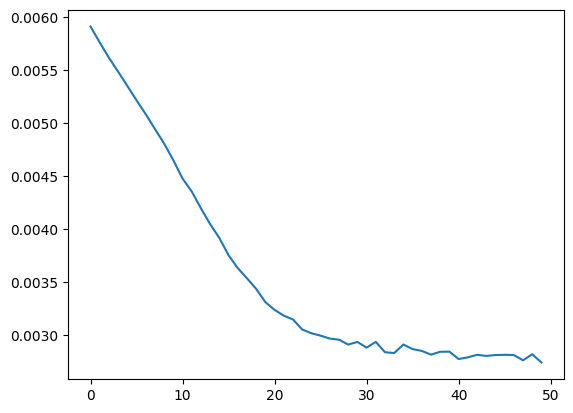

     -------------------val_aucs-------------


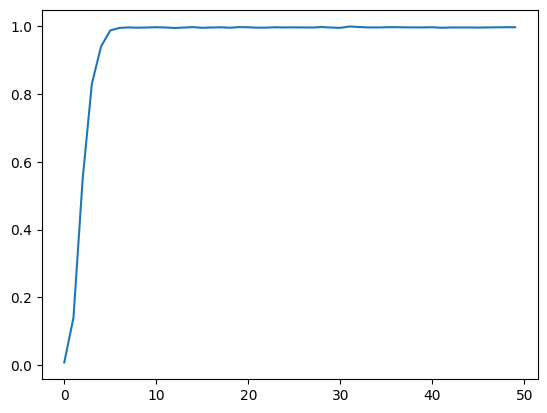

In [6]:

print("     ------------------- Loss ---------------")
plt.plot(train_losses)
plt.show()
print("     -------------------val_aucs-------------")
plt.plot(val_aucs)
plt.show()


In [7]:
!pip install seaborn

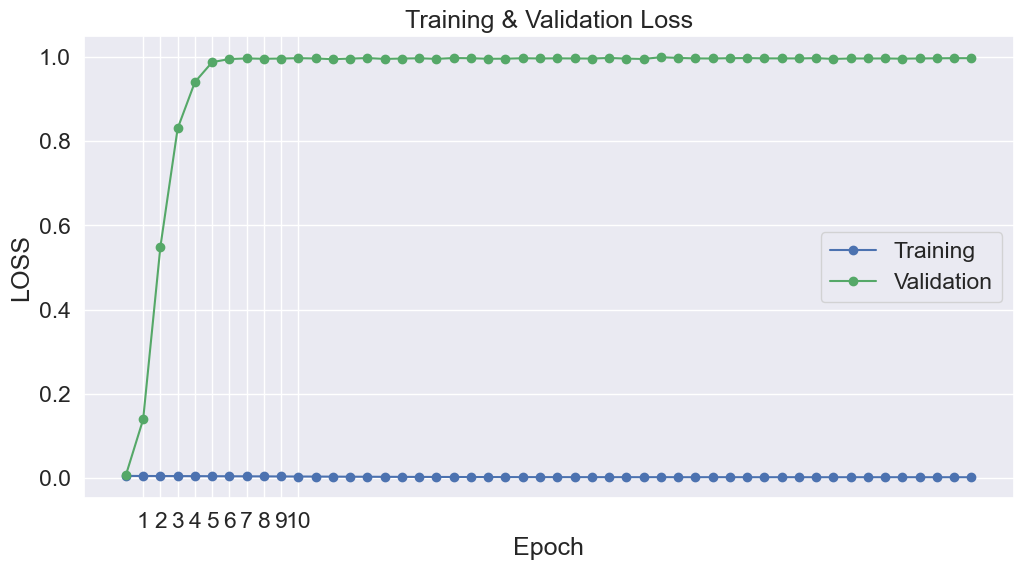

In [19]:
import seaborn as sns
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(train_losses, 'b-o', label="Training")

plt.plot(val_aucs, 'g-o', label="Validation")


# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("LOSS")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7,8,9,10])

plt.show()

In [9]:
p = torch.flatten(pred)

In [10]:
labels_batch_torch2 = torch.flatten(labels_batch_torch)

In [11]:
labels_batch_torch1.ravel()

NameError: name 'labels_batch_torch1' is not defined

In [ ]:
confusion_matrix(y_true, (y_pred > 0.5))
labels_batch_torch1 = labels_batch_torch1.detach().numpy()

In [ ]:
#p = p.detach().numpy()
p.ravel()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_batch_torch1, p > 0.1)
cm

In [14]:
TP = 938
FN = 62
FP = 1
TN = 999

In [15]:
Acc= (TP + TN )/ (TP + FN + FP +TN)
Acc

0.9685

In [16]:
#What proportion of positive identifications was actually correct?
Pre = TP/(TP+FP)
Pre

0.9989350372736954

In [17]:
# What proportion of actual positives was identified correctly?
Recall=  TP/(TP+FN)
Recall

0.938